## Testing of BLIP2-Pretrained Model

In [2]:
import os
import numpy as np

import numpy as np
import matplotlib.pyplot as plt

In [3]:
import sys
sys.path.append("/home/arafat/projects/flow_matching_and_llm")

# Fine Tuning

In [ ]:
import torch

from transformers import (
    Blip2Processor, 
    Blip2ForConditionalGeneration,
    Blip2VisionConfig,
    Blip2QFormerConfig,
    Blip2Config,
    BitsAndBytesConfig,
    TrainingArguments,
    Trainer
)

from peft import (
    LoraConfig, 
    get_peft_model, 
    prepare_model_for_kbit_training
)

**Download pre-processor**

In [ ]:
processor = Blip2Processor.from_pretrained('Salesforce/blip2-flan-t5-xl', cache_dir="../data/cache")

**Use Model with lower number of parameters and layers (Change the configuration)**

In [5]:
vision_config = Blip2VisionConfig(
    hidden_size=768,           # Reduced from 1408
    num_hidden_layers=12,      # Reduced from 39
    num_attention_heads=12,    # Reduced from 16
    intermediate_size=3072,    # Reduced from 6144
    image_size=224,            # Keep same
    patch_size=16,             # Adjusted from 14
)

qformer_config = Blip2QFormerConfig(
    hidden_size=512,           # Reduced from 768
    num_hidden_layers=8,       # Reduced from 12
    num_attention_heads=8,     # Reduced from 12
    intermediate_size=2048,    # Reduced from 3072
    num_query_tokens=16,       # Reduced from 32
)

config = Blip2Config(
    vision_config=vision_config.to_dict(),
    qformer_config=qformer_config.to_dict(),
    use_decoder_only_language_model=True,
)

In [6]:
model = Blip2ForConditionalGeneration(config=config)

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())

print(f"Trainable Parameter : {trainable_params/1e9} b")
print(f"Total Parameter : {total_params / 1e9} b")
print(f"Trainable Params Size: {trainable_params * 4/(1024 * 1024 * 1024):.3f} GiB")
print(f"Total Parameters Size: {total_params * 4/ (1024 * 1024 * 1024):.3f} GiB")

Trainable Parameter : 0.241923584 b
Total Parameter : 0.241923584 b
Trainable Params Size: 0.901 GiB
Total Parameters Size: 0.901 GiB


**Or Download A pre-trrained Model and Use train the Q-Former Only**

In [ ]:
model_name = "Salesforce/blip2-flan-t5-xl"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)
model = Blip2ForConditionalGeneration.from_pretrained(model_name,
                                                    quantization_config=bnb_config,
                                                    cache_dir="../data/cache")

In [47]:
# Prepare model for k-bit training (required for quantized models)
model = prepare_model_for_kbit_training(model)

lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q", "v"],
    lora_dropout=0.05,
    bias="none",
    task_type="SEQ_2_SEQ_LM"
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()


trainable params: 9,437,184 || all params: 3,951,883,776 || trainable%: 0.2388


In [8]:

for params in model.vision_model.parameters():
    params.requires_grad = False

for params in model.language_model.parameters():
    params.requires_grad = False
    
for params in model.qformer.parameters():
    params.requires_grad = True
    
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())

print(f"Trainable Parameter : {trainable_params/1e9} b")
print(f"Total Parameter : {total_params / 1e9} b")
print(f"Trainable Params Size: {trainable_params * 4/(1024 * 1024 * 1024):.3f} GiB")
print(f"Total Parameters Size: {total_params * 4/ (1024 * 1024 * 1024):.3f} GiB")

Trainable Parameter : 0.105137664 b
Total Parameter : 2.100131328 b
Trainable Params Size: 0.392 GiB
Total Parameters Size: 7.824 GiB


**Download & Save Dataset**

In [6]:
from datasets import load_dataset, load_from_disk

In [11]:
splits = ["train", "validation", "test"]
if os.path.exists("../data/flickr8k/train") and os.path.exists("../data/flickr8k/test") and os.path.exists("../data/flickr8k/validation"):
    print("Dataset Already Exists")
else:    
    flickr8k = load_dataset("jxie/flickr8k", split=splits)
    for idx, split in enumerate(splits):
        directory = f"../data/flickr8k/{split}"
        os.makedirs(directory, exist_ok=True)
        flickr8k[idx].save_to_disk(dataset_path=directory)

Dataset Already Exists


In [10]:
train_dataset = load_from_disk("../data/flickr8k/train")

**Some samples**

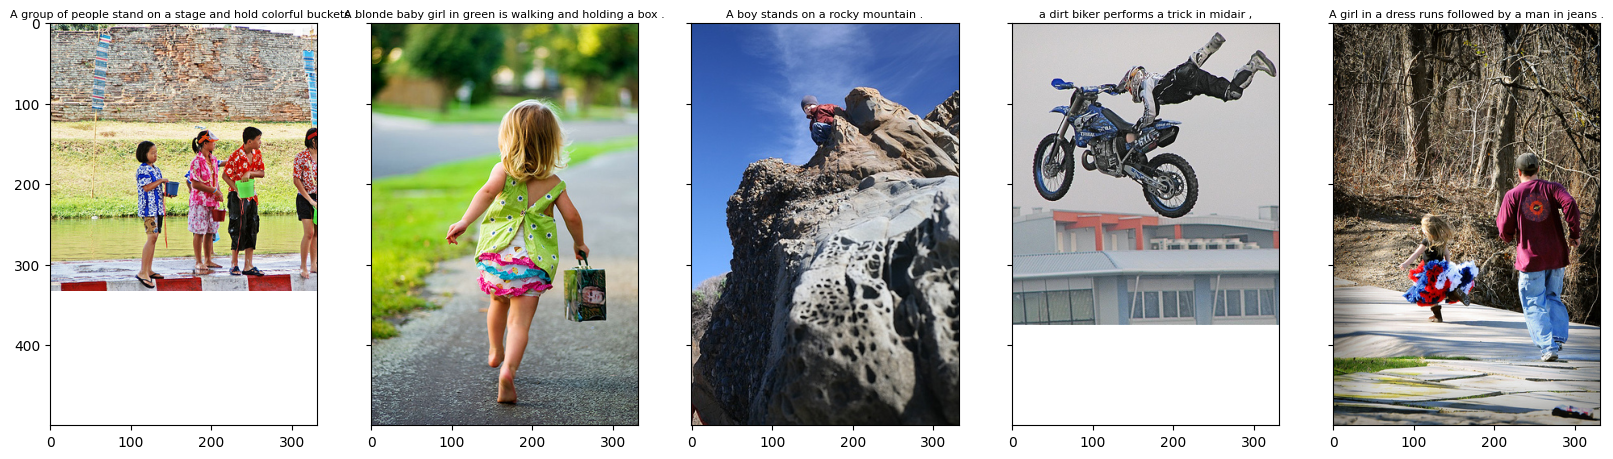

In [98]:
fig, axes = plt.subplots(1,5, figsize=(20, 20), sharex=True, sharey=True)
index = np.random.randint(0, len(train_dataset)-5)
for i in range(len(axes)):
    axes[i].imshow(train_dataset[index+i]['image'])
    caption = train_dataset[index+i]['caption_0']
    axes[i].set_title(caption, fontsize=8, fontweight="light", pad=4)

**Dataset Class**

In [16]:
from torch.utils.data import Dataset, DataLoader

In [ ]:
from typing import Any


class ImageCaptioning(Dataset):
    def __init__(self, file_path:str, processor:Blip2Processor):
        super().__init__()
        assert os.path.exists(file_path), "File does not exists"
        self.data = load_from_disk(file_path)
        self.processor = processor
        self.current_epoch = 0
        
    
    def set_epoch(self, epoch):
        self.current_epoch = epoch
        
    
    def __len__(self):
        return len(self.data)
    
    
    def __getitem__(self, index):
        image = self.data[index]['image']
        cap_idx = self.current_epoch % 5
        # cap_idx = np.random.randint(0, 5)
        cap_idx = f"caption_{cap_idx}"
        caption = self.data[index][cap_idx]
        return image, caption
    
    
    def collate_fn(self, batch):
        images, captions = zip(*batch)
        
        encoding = self.processor(
            images=list(images),
            text=list(captions),
            padding="longest",
            truncation=True,
            return_tensors="pt"
        )
        
        return encoding['pixel_values'], encoding['input_ids'], encoding['attention_mask']
    
        # return {
        #     "pixel_values":encoding['pixel_values'], 
        #     "input_ids": encoding["input_ids"], 
        #     "attention_mask": encoding["attention_mask"]
        # }
        

In [56]:
img_cap_dataset = ImageCaptioning("../data/flickr8k/train", processor=processor)
dataloader = DataLoader(img_cap_dataset, batch_size=5, shuffle=False, collate_fn=img_cap_dataset.collate_fn)

In [58]:
dict_object = next(iter(dataloader))
pixel_values = dict_object['pixel_values']
input_ids = dict_object['input_ids']
mask = dict_object['attention_mask']
pixel_values.shape, input_ids.shape, mask.shape

(torch.Size([5, 3, 224, 224]), torch.Size([5, 54]), torch.Size([5, 54]))

**Metrics for Evaluation**

In [39]:
import evaluate

bleu_metric = evaluate.load("bleu")
meteor_metric = evaluate.load("meteor")
rouge_metric = evaluate.load("rouge")

[nltk_data] Downloading package wordnet to /home/arafat/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/arafat/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/arafat/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Pytorch Lightning Model

In [1]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, Callback

In [7]:
class LightningWrapper(pl.LightningModule):
    def __init__(self, model:Blip2ForConditionalGeneration, processor:Blip2Processor):
        super().__init__()
        self.model = model
        self.processor = processor


    def forward(self, pixel_values:torch.Tensor, input_ids:torch.Tensor, attention_mask:torch.Tensor):
        return self.model(input_ids=input_ids, pixel_values=pixel_values, labels=input_ids)
    
    def generate(self, pixel_values:torch.Tensor):
        return self.model.generate(pixel_values=pixel_values)


    def training_step(self, batch, batch_idx):
        pixel_values, input_ids, attention_mask = batch
        output = self(pixel_values, input_ids, attention_mask)
        loss = output.loss

        self.log('train_loss_batch', loss.item(), on_step=True, on_epoch=True, prog_bar=True)
        return loss

    
    def validation_step(self, batch, batch_idx):
        pixel_values, input_ids, attention_mask = batch
        generated_ids = self.generate(pixel_values)
        metrics = self.compute_metrics_multi_ref((generated_ids, input_ids))
        self.log(metrics)
        
    
    def on_train_epoch_end(self):
        avg_loss = self.trainer.callback_metrics.get('train_loss_batch')
        self.log('train_loss', avg_loss)
        print(f"Epoch : {self.current_epoch}/{self.trainer.max_epochs} | Training_loss : {avg_loss:.6f}")
    

    def on_validation_epoch_end(self, outputs, batch, batch_idx, dataloader_idx = 0):
        bleu = self.trainer.callback_metrics.get('bleu')
        meteor = self.trainer.callback_metrics.get('meteor')
        rouge = self.trainer.callback_metrics.get('rougeL')

        self.log({
            "bleu":bleu,
            "meteor":meteor,
            "rouge":rouge
        })

        print(f"Epoch : {self.current_epoch}/{self.trainer.max_epochs} | BLEU : {bleu:.6f}")
        print(f"Epoch : {self.current_epoch}/{self.trainer.max_epochs} | METEOR : {meteor:.6f}")
        print(f"Epoch : {self.current_epoch}/{self.trainer.max_epochs} | ROUGE : {rouge:.6f}")

        
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr,  betas=(0.9, 0.999), weight_decay=0.01)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=self.trainer.max_epochs,
            eta_min=1e-6
        )
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'interval': 'epoch'
            }
        }
    
    def compute_metrics_multi_ref(self, eval_pred):
        predictions, labels = eval_pred
        
        decoded_preds = self.processor.batch_decode(predictions, skip_special_tokens=True)
        decoded_preds = [pred.strip() for pred in decoded_preds]
        
        decoded_labels = self.processor.batch_decode(labels, skip_special_tokens=True)
        decoded_labels = [label.strip() for label in decoded_labels]
        
        # BLEU - correct format
        bleu_result = bleu_metric.compute(
            predictions=decoded_preds,
            references=[[label] for label in decoded_labels]
        )
        
        # METEOR - needs list of lists format
        meteor_result = meteor_metric.compute(
            predictions=decoded_preds,
            references=[[label] for label in decoded_labels]  # Changed from decoded_labels
        )
        
        # ROUGE - needs list of lists format
        rouge_result = rouge_metric.compute(
            predictions=decoded_preds,
            references=[[label] for label in decoded_labels]  # Changed from decoded_labels
        )
        
        return {
            "bleu": bleu_result["bleu"],
            "bleu_1": bleu_result["precisions"][0],
            "bleu_2": bleu_result["precisions"][1],
            "bleu_3": bleu_result["precisions"][2],
            "bleu_4": bleu_result["precisions"][3],
            "meteor": meteor_result["meteor"],
            "rouge1": rouge_result["rouge1"],
            "rouge2": rouge_result["rouge2"],
            "rougeL": rouge_result["rougeL"],
        }
    
    
    def get_model(self):
        return self.model

In [ ]:
checkpoint_callback = ModelCheckpoint(
    dirpath='../model/',
    filename=f'blip2_sft_{{epoch}}',
    save_top_k=2,
    save_last=True,
    monitor='bleu',
    mode='min'
)

class PrintCallback(Callback):
    def on_train_start(self, trainer, pl_module):
        print("Training started!")
    def on_train_end(self, trainer, pl_module):
        print("Training is done.")

In [8]:
BLIP2 = LightningWrapper(model=model, processor=processor)

NameError: name 'model' is not defined

In [13]:
model.eval()
output = model(input_ids=input_ids, pixel_values=pixel_values, labels=input_ids)
loss = output.loss

In [7]:
val_dataset = load_from_disk("../data/flickr8k/validation")

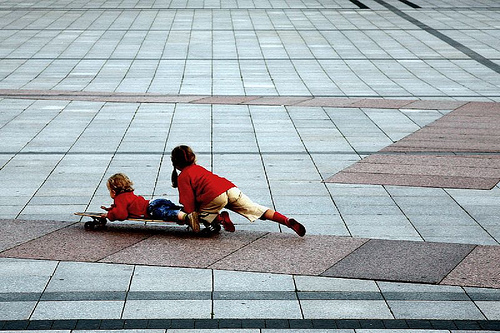

In [12]:
val_dataset[0]['image']